# Распределения

Мы с вами разобрали линейную регрессию:
$$y = Xw + eps$$
и говорили, что будем находить параметры минимизирую следующую функцию потерь:
 $$L(X,w,y) = \sum_{i=1}^n {(y_i - \sum_iw_i * x_i)}^2  = (y-Xw)^T(y-Xw) $$

А почему именно такую? а может ли быть какая-то другая функция? а если не может, то почему?

На эти вопросы оказывается есть ответ, если посмотреть на это с вероятностной точки зрения.
Вспомним про вероятности и распределения сначала. Но сначала посмотрим на данные, которые могут встречаться.  Так как в машинном обучении нас интересует целевая переменная  - будем смотреть на целевую переменную. Нарисуйте гистограммы для всех таргетов.

Смотрите https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats as sts
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


### Пример из диагностики

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
#print(data['DESCR'])

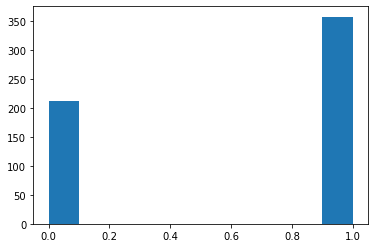

In [4]:
plt.hist(data['target']);

## Оценка стоимости

In [80]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

In [81]:
#?plt.hist

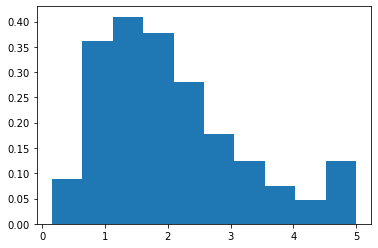

In [82]:
#print(data['DESCR'])
plt.hist(data['target'],density = True);

### Моделирование страховых выплат
Моделирование страховых случаев
https://www.openml.org/d/41214
The dataset freMTPL2freq contains risk features for 677,991 motor third-part liability policies (observed mostly on one year).



In [83]:
from sklearn.datasets import fetch_openml
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(np.int)
    df_freq.set_index('IDpol', inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby('IDpol').sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == np.object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]

In [84]:
df = load_mtpl2(n_samples=10000)

In [85]:
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)
df.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0


<AxesSubplot:>

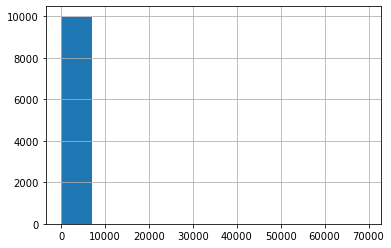

In [86]:
df['ClaimAmount'].hist()

<AxesSubplot:>

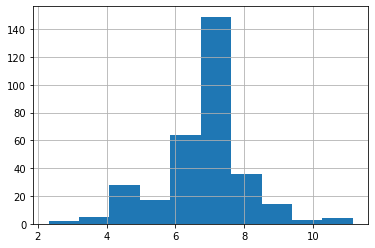

In [87]:
np.log(df[df.ClaimAmount>0]['ClaimAmount']).hist()

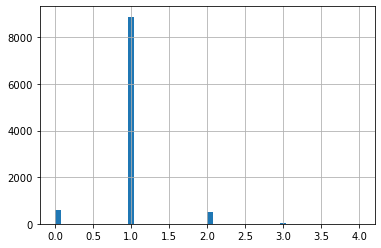

In [88]:
df.ClaimNb.hist(bins = 50);

<AxesSubplot:>

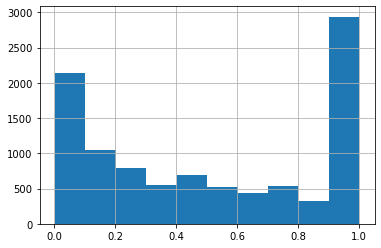

In [89]:
df.Exposure.hist()

Все эти гистограммы есть реализация каког-то случайного процесса. Но какого? Разбором процессов, которые могут порождать данные и занимается статистика и теория вероятности. Разберем основные распределения.

## Распределения

### Распределение Бернулли
Схема Бернулли
Случайная величина может принимать всего два значения 0 и 1. Несмотря на кажущуюся простоту моделирует многие процессы. Формально, процесс устроен так, что величина может принимать с заданной вероятностью p значение 1  и 0 с вероятностью (1-p). Свободным параметром является число итераций n процесса. Случайное распределение, которое моделируется такой схемой, называется биномиальным распределением. Биномиальное распределение - это распределение вероятности числа успехов в случае n итераций схемы бернулли. 

К каким данных из рассмотренных выше подходит?

Примеры значений которые может принимать распределение [0 1 1 1 1 1 1 1 0 1]
Среднее одиночной выборки: 0.80


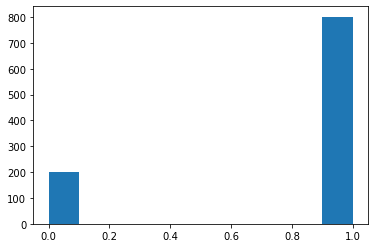

In [90]:
# примеры
fake_bin = sts.bernoulli.rvs(p = 0.8, size=1000)
print(f'Примеры значений которые может принимать распределение {fake_bin[:10]}')
print(f'Среднее одиночной выборки: {np.mean(fake_bin):.2f}')
plt.hist(fake_bin);

### Распределение Пуассона

Дискретное распределение, которое моделирует случайную величину  представляющую собой число событий, произошедших за фиксированное время, при условии, что данные события происходят с некоторой фиксированной средней интенсивностью и независимо друг от друга. 
$$P(k)=\frac{\lambda^k}{k!}exp(-\lambda)$$

Распределение Пуассона является пределом биномиального распределения для редких событий. Представим себе, что мы проводим испытание Бернулли каждую минуту в течение часа, с одной и той же вероятностью успеха 0.1. Мы проведем 60 испытаний,ожидаемое число успехов  будет $n*p = 6$. и мы ожидаем получить около 6 успехов. Это будет распределением Пуассона, где мы получаем в среднем 6 посетителей в час (В каждый конкретный час число будет разное!). Таким образом, распределение Пуассона с коэффициентом равным $\lambda = n*p$, аппроксимирует биномиальное распределение для $n$ испытаний Бернулли с вероятностью $p$ успеха (с $n$ большим и $p$ малым). Важно отметить, что c распределением Пуассона проще работать, поскольку оно имеет только один параметр вместо двух.
С помощью этого распределения можно моделировать и другие события счетчики

In [91]:
#?sts.poisson

Примеры значений которые может принимать распределение [0 2 0 1 1 0 0 3 1 0]
Среднее одиночной выборки: 1.03


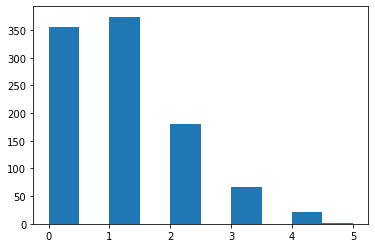

In [92]:
# примеры
fake_poi = np.random.poisson(lam = 1, size=1000)
print(f'Примеры значений которые может принимать распределение {fake_poi[:10]}')
print(f'Среднее одиночной выборки: {np.mean(fake_poi):.2f}')
plt.hist(fake_poi);

### Непрерывные распределения 
### Экспоненциальное распределение
Непрерывное положительно-определенное распределение (значит какое угодно число больше нуля может принимать), c помощью которого можно моделировать время между двумя событиями, например время между прибытием автобусов на остановку, рождения детей, временем между визитами посетителей в ресторане , счастливых моментов в неделе:).
У него есть параметр, который можно интерпертировать как среднее число событий  в единицу времени


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Exponential_distribution_pdf.svg/650px-Exponential_distribution_pdf.svg.png" alt="Drawing" style="width: 300px;"/>


Примеры значений которые может принимать распределение [1.32657126e-01 2.37364154e+00 7.31862867e-01 4.69609699e+00
 3.25414605e-03 1.87705260e+00 1.28454950e+00 5.73437142e-01
 1.93136741e+00 5.38298360e+00]
Среднее одиночной выборки: 2.06


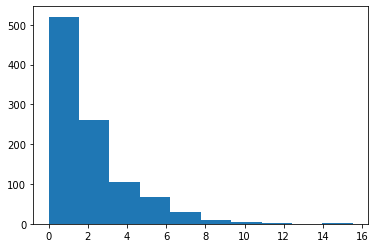

In [93]:
# примеры
fake_expon = np.random.exponential(scale = 2, size=1000)
print(f'Примеры значений которые может принимать распределение {fake_expon[:10]}')
print(f'Среднее одиночной выборки: {np.mean(fake_expon):.2f}')
plt.hist(fake_expon);

### Гамма распределение
Общий случай экспоненциального распределения, уже двухпараметрическое. Определено в положительной полуплоскости. Плотность распределения

Говорят, что случайная величина  $X$ имеет гамма-распределение с параметрами $\theta$ и $k$. Пишут $\Gamma (k,\theta )$, если плотность вероятности имеет вид:

$$f_{X}(x)=\left\{{\begin{matrix}x^{{k-1}}{\frac  {e^{{-x }}}{\Gamma (\theta)}},&x\geq 0\\0,&x<0\end{matrix}}\right.$$
Гамма  распределение широко используется в байесовской статистике и является сопряженным к распределению Пуассона.  
В данном варианте (нормированный вариант, иногда распределение задается двумя параметрами) матожидание и дисперсия равны параметру a 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/650px-Gamma_distribution_pdf.svg.png" alt="Drawing" style="width: 400px;"/>


Примеры значений которые может принимать распределение [13.98179904 12.03167535 23.6915095  18.36159601 18.42729823 23.549186
  9.12345613 24.58062545 17.3162302  19.61008783]
Среднее одиночной выборки: 17.80


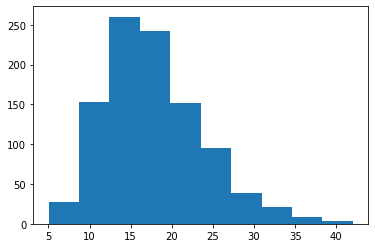

In [94]:
# примеры
fake_gamma = np.random.gamma(9, scale = 2, size=1000)
print(f'Примеры значений которые может принимать распределение {fake_gamma[:10]}')
print(f'Среднее одиночной выборки: {np.mean(fake_gamma):.2f}')
plt.hist(fake_gamma);

### Распределение Твиди (Tweedie distribution)

Включает в себя как непрерывные (Гамма,Нормальное), так и дискретные распределения (Пуассон).
Специальное распределение, которое умеет моделировать например такие процессы у которых большая концентрация вещества в нуле, а остальные распределены как-то иначе, например по Пуассону или Гамма

<img src="https://miro.medium.com/max/1234/1*7zgUbwL_MPhEEJ8Ad11USA.png" alt="Drawing" style="width: 400px;"/>

Взято из https://towardsdatascience.com/insurance-risk-pricing-tweedie-approach-1d71207268fc


Вообще есть специальный класс который делает тоже самое ( Zero inflated Poisson) 
Но в sklearn его нет, а твиди есть

In [95]:
def tweedie(p,mu,phi,size = 1000):
    #checking the value of variance power between 1-2
    assert (p<2) or (p>1), 'p must be between (1,2)'

    rt=np.full(n,np.nan)
    # calculating mean of poisson distribution
    lambdaa=mu**(2-p)/(phi*(2-p))
    # shape parameter of gamma distribution
    alpha=np.abs((2-p)/(1-p))
    # scale parameter of gamma distribution
    gam= phi*(p-1)*(mu**(p-1))
    # Generating Poisson random sample
    N=np.random.poisson(lam =lambdaa,size = size)
    rt = np.random.gamma(N*alpha,scale = gam)
    return(rt)

Примеры значений которые может принимать распределение [ 1.27138693  4.46443485  0.         11.44083016  0.07092756  2.88570105
  2.76490232  3.41308099  0.          1.40605245]
Среднее одиночной выборки: 1.88


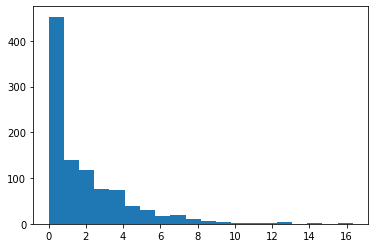

In [96]:
p,mu,phi = 1.5,2,2
fake_tw = tweedie(p,mu,phi)
print(f'Примеры значений которые может принимать распределение {fake_tw[:10]}')
print(f'Среднее одиночной выборки: {np.mean(fake_tw):.2f}')
plt.hist(fake_tw, bins = 20);

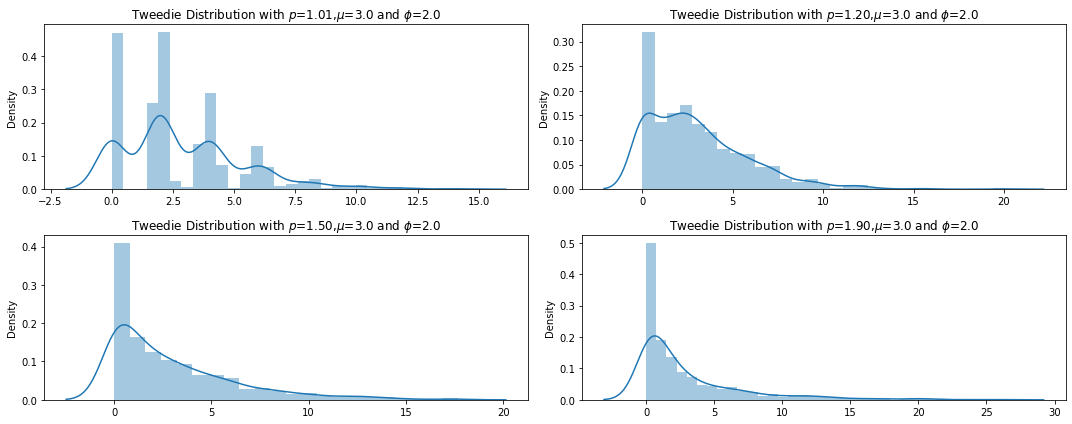

In [97]:
vals=[1.01,1.2,1.5,1.9]
fig, axes =plt.subplots(2,2, figsize=(15,6))
axes=axes.flatten()
for ax,i in zip(axes,vals):
    s_tweedie=tweedie(i,3,2)
    sns.distplot(pd.DataFrame(s_tweedie),ax=ax).set_title('Tweedie Distribution with $p$=%.2f,$\mu$=%.1f and $\phi$=%.1f'%(i,3,2))
plt.tight_layout()
plt.show()

### Нормальное распределение  

Ну и уже встречавшееся нам чудесное нормальное распределение

In [98]:
#?sts.norm

Примеры значений которые может принимать распределение [ 0.66061757 -0.17369626 -0.92775483 -0.71490373 -0.2479332  -0.08778156
  0.76083042  0.14218751 -0.94195993  1.21862848]
Среднее одиночной выборки: 0.03


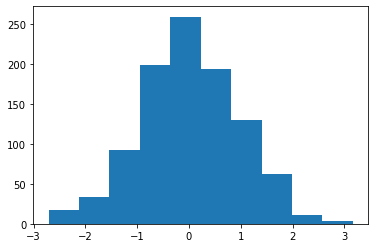

In [98]:
# примеры
fake_norm = np.random.normal(loc=0,scale=1, size=1000)
print(f'Примеры значений которые может принимать распределение {fake_norm[:10]}');
print(f'Среднее одиночной выборки: {np.mean(fake_norm):.2f}');
plt.hist(fake_norm);

### Статистики распределения

Посмотрели на разные формы распределений. Как их можно описывать? 

Задана выборка из случайной величины (или реализация)
$$X^n = (X_1,X_2,....,X_n)$$
    
Статистикой называется любая функция от выборки

Для дискретных величин, заданных функцией вероятности:

$$X \in A = {a_1,a_2,...,a_n}, P(X=a_k) = p_k$$
Для такой выборки лучшей оценкой вероятности будет $\frac{1}{n}\sum [X_i=a_k]$
И мы можем построить эмпирическую функцию распределения 
$$F_n(x)=\frac{1}{n}[X_i\leq x]$$    
    
Но есть ряд статистик, которые наиболее распространены при описании функции распределения

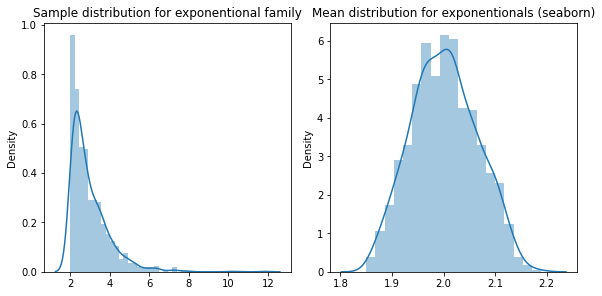

In [99]:
#Сделаем много таких выборок и посчитаем из каждой из них среднее
means_exp = np.array([np.mean( np.random.exponential(scale = 2, size=1000)) for i in range(1000)])
_,ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

sns.distplot(sts.expon.rvs(loc = 2, size=1000), ax = ax[0])
ax[0].set_title('Sample distribution for exponentional family');
sns.distplot(means_exp, ax = ax[1])
ax[1].set_title('Mean distribution for exponentionals (seaborn)');

## Центральная предельная теорема

Рассмотрим случайную величину $X$ с какой то функцией распределения $F(x)$ и ее выборку размера $n$  $\{X_1, X_2, X_3, ..., X_n\}$ .   По выборке можно вычислить выборочное среднее $$\frac{1}{n}\sum [X_i]$$.
А если у нас есть еще одна выборка из этого же распределения? А если их много? Какое распределение будет у среднего значения этих выборок?

ЦПТ утверждает что при большом количестве испытаний выборочное среднее стремится к нормальному распределению:

$$\frac{\bar{X_n}-\mu}{\sqrt{N}\sigma} \sim N(0,1)$$

!! Самая важная теорема которая позволяет делать очень многие выводы в статистике